In [1]:
import os
import re

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
wd = os.getcwd()
parasitized_path = wd + "\\Parasitized"
uninfected_path = wd + "\\Uninfected"

In [2]:
import cv2
import numpy as np

for _, _, filenames_p in  os.walk(parasitized_path):
    filenames_p = filenames_p

for _, _, filenames_u in  os.walk(uninfected_path):
    filenames_u = filenames_u

images = []
labels = []
for name in filenames_p:
    path = parasitized_path + "\\" + name
    image = cv2.imread(path)
    if image is not None:
        images.append(image)
        labels.append(1)

for name in filenames_u:
    path = uninfected_path + "\\" + name
    image = cv2.imread(path)
    if image is not None:
        images.append(image)
        labels.append(0)

images = np.array(images, dtype="object")
labels = np.array(labels)



In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

def prepare(image_group, plot):
    x = np.array([image.shape[0] for image in image_group])      
    y = np.array([image.shape[1] for image in image_group])
    
    if plot=="box":
        fig, axs = plt.subplots(ncols=2,figsize=(15, 6))
        sns.boxplot(x=x, ax=axs[0])
        axs[0].title.set_text("X")
        sns.boxplot(x=y, ax=axs[1])
        axs[1].title.set_text("Y")
    if plot=="scatter":
        sns.scatterplot(x=x,y=y)
    plt.show()

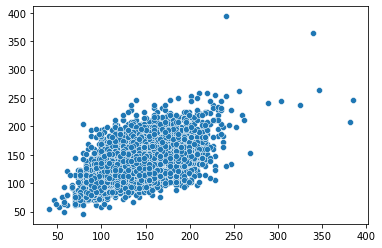

In [4]:
prepare(images, plot="scatter")

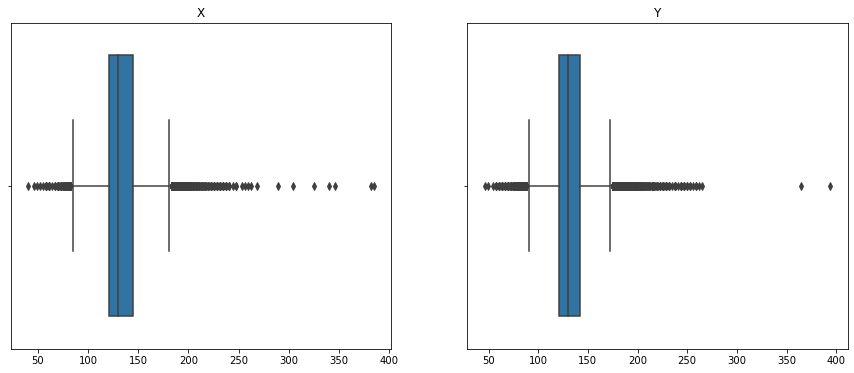

In [5]:
prepare(images, plot="box")

In [6]:
outlier_count = len([1 for image in images if (image.shape[0]>250 or image.shape[1]>250)])
percentage = outlier_count*100/(images.shape[0])
print("outlier count:%d ---------------- outlier percentage:%s" % (outlier_count,percentage))

outlier count:18 ---------------- outlier percentage:0.06531678641410843


In [7]:
images.shape

(27558,)

In [8]:
images_fix = np.array([image for image in images if (image.shape[0]<=250 and image.shape[1]<=250)], dtype="object")
labels_fix = np.array([labels[i] for (i, image) in enumerate(images) if (image.shape[0]<=250 and image.shape[1]<=250)])

In [9]:
batch_size = images_fix.shape[0]

In [10]:
def construct_image_batch(image_group, BATCH_SIZE):
    # get the max image shape
    max_shape = (250,250,3)
    # construct an image batch object
    image_batch = np.zeros((BATCH_SIZE,) + max_shape, dtype='float16')
    # copy all images to the upper left part of the image batch object
    for image_index, image in enumerate(image_group):
        image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

    return image_batch

In [11]:
image_fixed = construct_image_batch(images_fix, batch_size)

In [12]:
from tensorflow import keras
import tensorflow as tf

def CNN_model():
    
    # Input layer
    input_shape = (250,250,3)

    model = keras.Sequential([

        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=input_shape),
        keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same"),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=input_shape),
        keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same"),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(filters=32, kernel_size=(2,2), activation="relu", input_shape=input_shape),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same"),
        keras.layers.BatchNormalization(),

        keras.layers.Flatten(),
        keras.layers.Dense(128,activation="relu"),
        keras.layers.Dropout((0.2)),
        keras.layers.Dense(64,activation="relu"),
        keras.layers.Dropout((0.2)),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dropout((0.2)),  
        keras.layers.Dense(1, activation="sigmoid")
    ])

    print(model.summary())
    return model

In [13]:
model = CNN_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                        

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
def trrain(model, train_images, train_labels):
    
    X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, train_size=0.3, random_state=101)
    
    X_train, X_test, y_train, y_test = X_train.astype("float16"), X_test.astype("float16"),y_train.astype("float16"), y_test.astype("float16")
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',metrics=['accuracy'])

    model.fit(X_train,y_train, validation_split=0.2, epochs=10, verbose=1, batch_size=64)
    
    return model    

In [16]:
np.unique(labels_fix).shape

(2,)

In [17]:
asdsad

NameError: name 'asdsad' is not defined

In [ ]:
modelsaved = trrain(model, image_fixed, labels_fix)

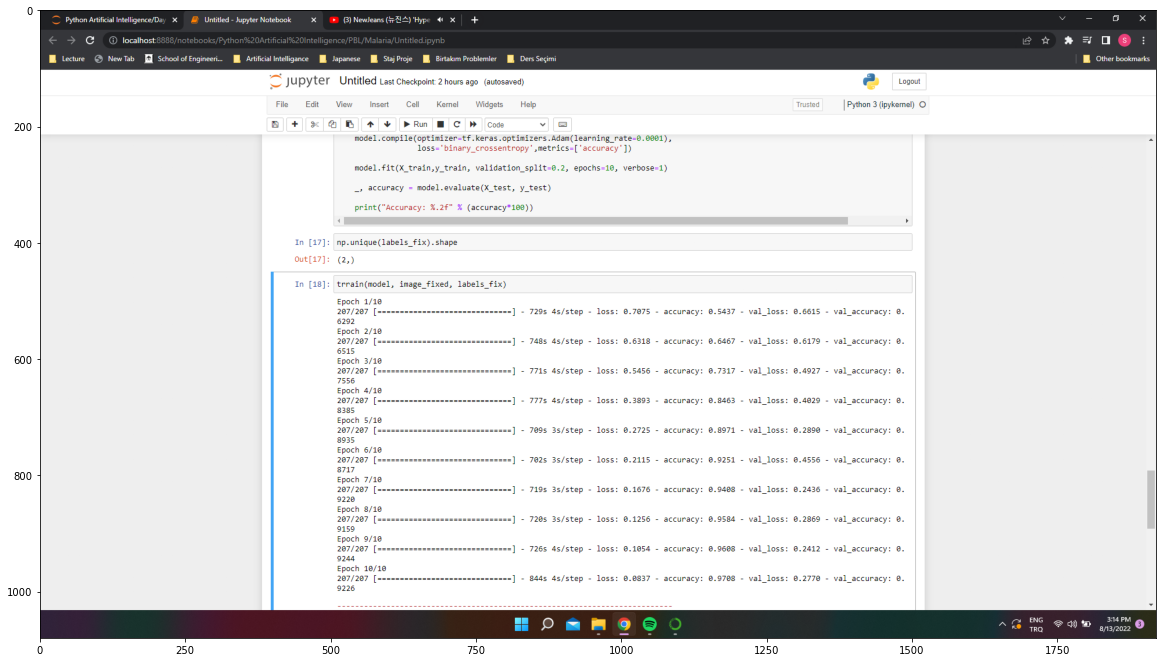

In [18]:
# Model takes too much time to train and ram is always low for image classification in my case
ss = plt.imread("Model_Screenshot.png")
plt.figure(figsize=(20,12))
plt.imshow(ss)

In [ ]:
modelsaved.save("C:\\Users\\samet\\Python Artificial Intelligence\\PBL\\Malaria\\malaria.h5", save_format="h5")

In [ ]:
_, accuracy = modelsaved.evaluate(X_test, y_test)

print("Accuracy: %.2f" % (accuracy*100))

In [19]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(image_fixed, labels_fix, train_size=0.3, random_state=101)

X_train,X_test,y_train,y_test=X_train.astype("float16"),X_test.astype("float16"),y_train.astype("float16"),y_test.astype("float16")
modelsaved = tf.keras.models.load_model('malaria.h5')
_, accuracy = modelsaved.evaluate(X_test, y_test)

print("Accuracy: %.2f" % (accuracy*100))

MemoryError: Unable to allocate 6.73 GiB for an array with shape (19278, 250, 250, 3) and data type float16